In [8]:
%%time
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from concurrent.futures import ThreadPoolExecutor
from sklearn.decomposition import PCA
from PIL import Image
import os
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import IncrementalPCA

# 讀取 CSV 檔案
df = pd.read_csv('./final_raw.csv')

# 根據 'span' 欄位篩選數據
sampled_df_list = []
for category in df['span'].unique():
    category_df = df[df['span'] == category]
    sample_n = min(len(category_df), 15000)  # 每個類別取 15000 筆
    sampled_df_list.append(category_df.sample(n=sample_n, random_state=42))  # 隨機取樣

# 合併篩選後的數據
df = pd.concat(sampled_df_list)

# 圖片處理函數
def process_image(image_name):
    image_path = os.path.join(images_folder, image_name)
    with Image.open(image_path) as img:
        return np.array(img.convert('L').resize((64, 64))).flatten()

# 設定您的圖片文件夾路徑
images_folder = './flipped_img'

# 處理所有圖片並將其作為特徵
with ThreadPoolExecutor(max_workers=12) as executor:
    df['image'] = list(executor.map(process_image, df['pic_id']))

# 將圖片數據展平並轉換為 NumPy 陣列
X_images = np.array(df['image'].tolist())

# 初始化 Incremental PCA，設定 n_components 為 16
incremental_pca = IncrementalPCA(n_components=16)

# IncrementalPCA 降維，記憶體炸裂，分10批
for batch in np.array_split(X_images, 10):  
    incremental_pca.partial_fit(batch)

# 對圖片數據應用 PCA 降維
X_images_pca = incremental_pca.transform(X_images)

CPU times: total: 47min 51s
Wall time: 5min 56s


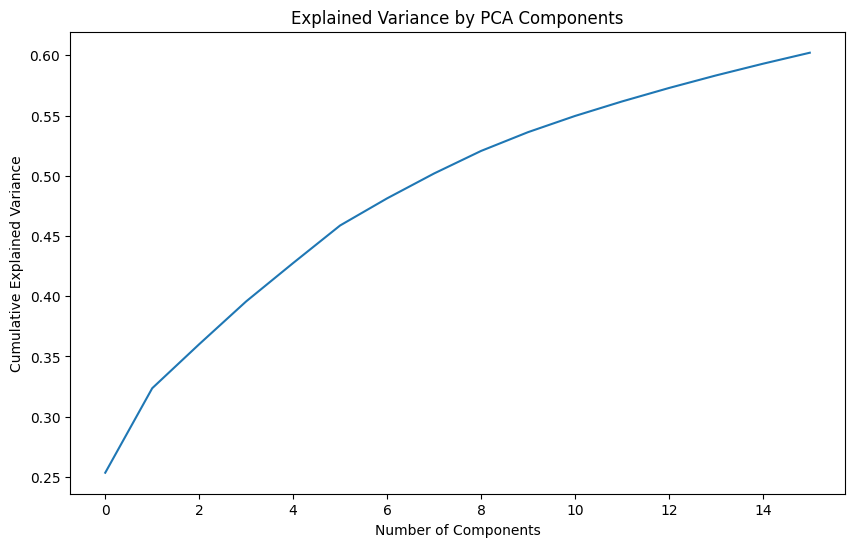

In [9]:
#PCA的方差解釋率
plt.figure(figsize=(10, 6))
explained_variance_ratio = incremental_pca.explained_variance_ratio_
plt.plot(np.cumsum(explained_variance_ratio))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.show()

C:\Users\student\anaconda3\envs\da\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


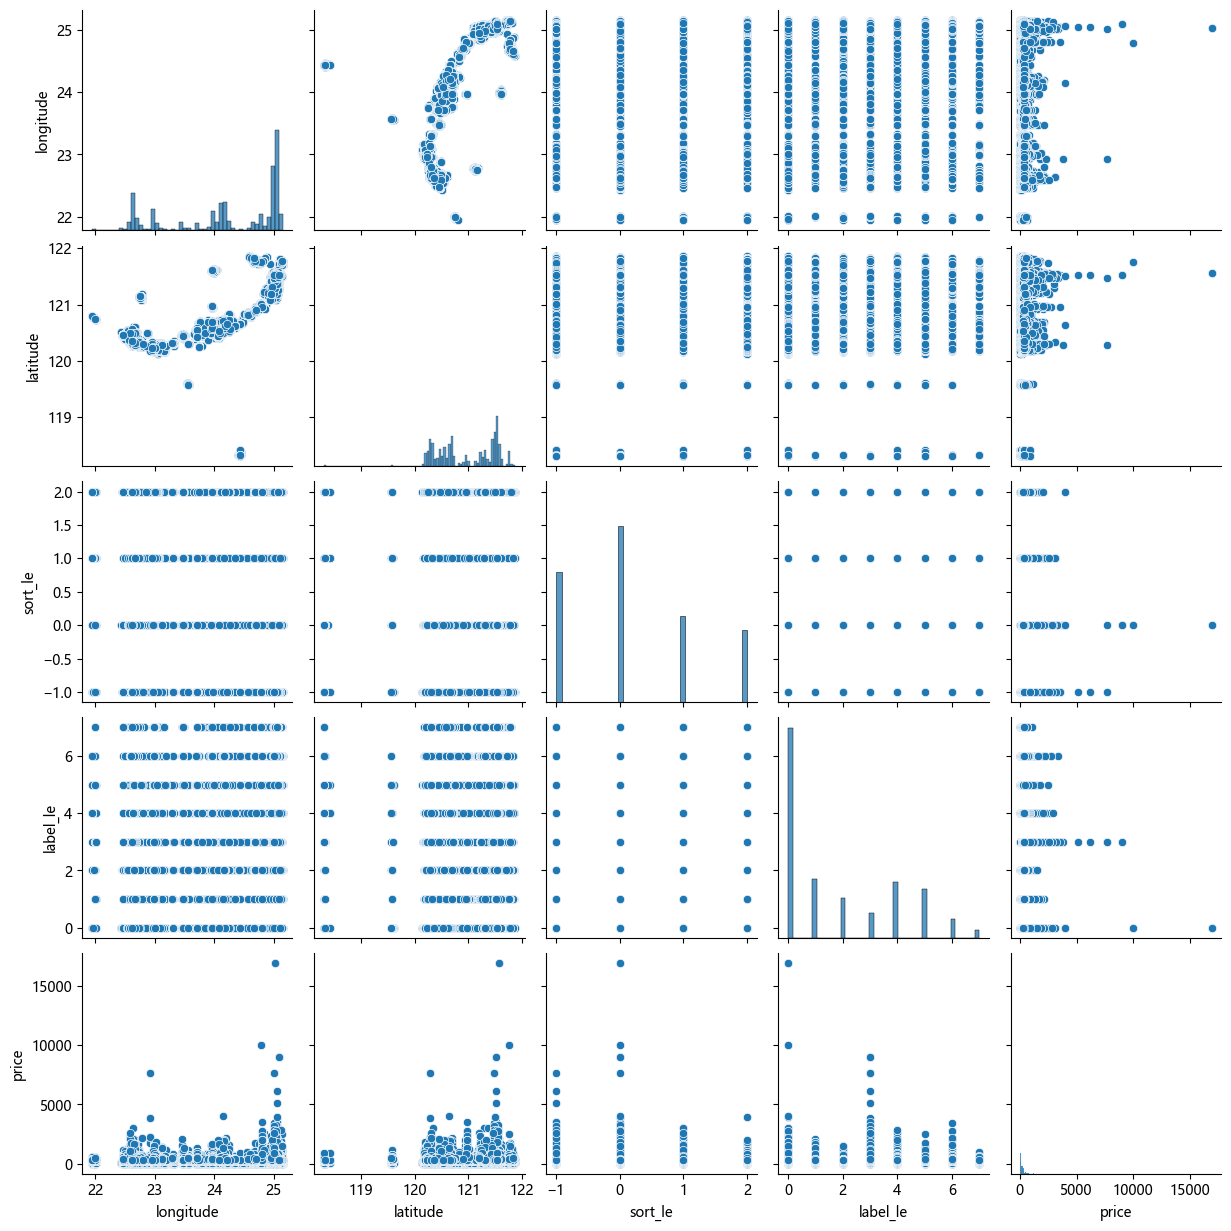

In [12]:
#散點圖們
plt.rcParams['font.family'] = ['Microsoft YaHei']
sns.pairplot(df[['longitude', 'latitude', 'sort_le', 'label_le', 'price']])
#sns.pairplot(df[['longitude', 'latitude', 'sort', 'label', 'price']], height=2, aspect=2)
# 繪製 'sort' 列的計數圖


<Axes: >

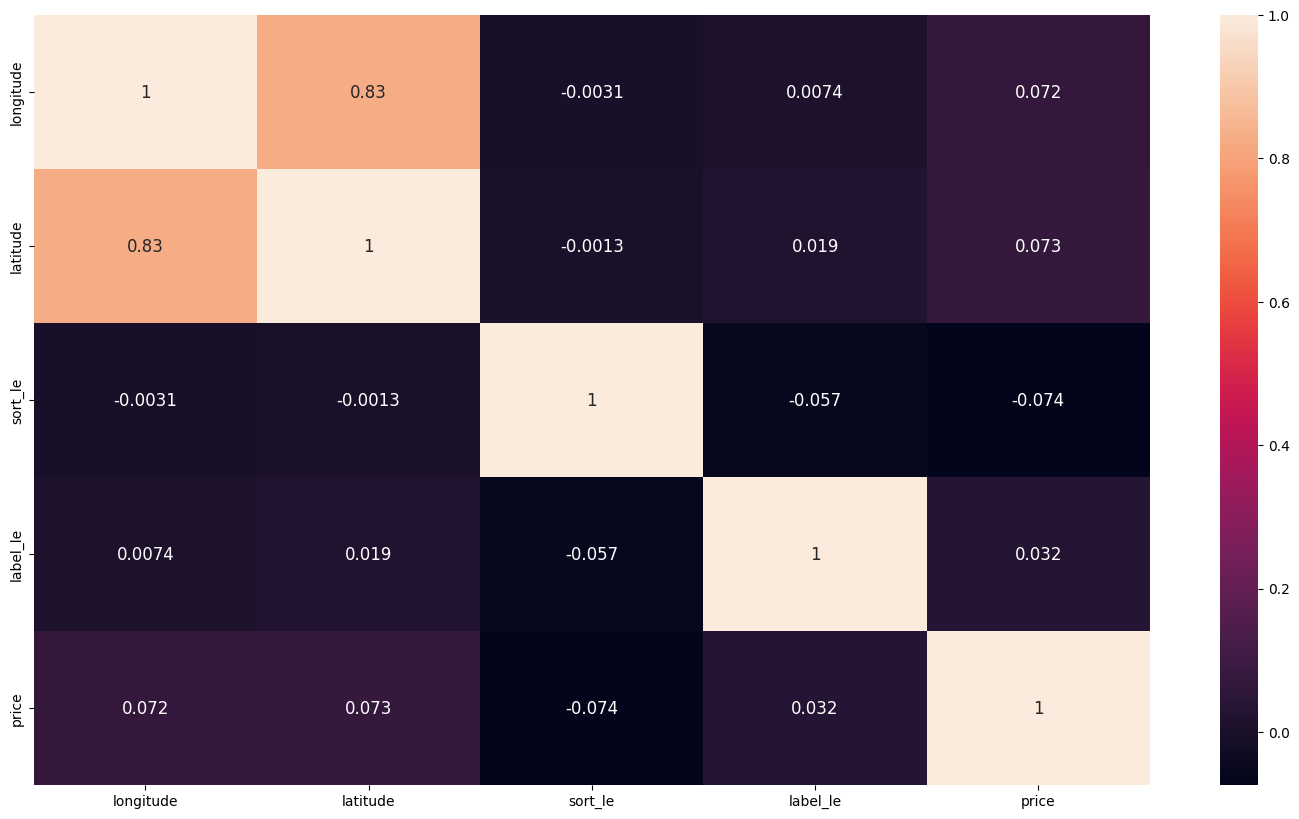

In [11]:

#熱力圖
selected_columns = df[['longitude', 'latitude', 'sort_le', 'label_le', 'price']]
corrmat = selected_columns.corr()
fig, ax = plt.subplots(figsize=(18, 10))
sns.heatmap(corrmat, annot=True, annot_kws={'size': 12})


In [10]:
#類別標籤編碼
df['sort_le'] = pd.factorize(df['sort'])[0]
df['label_le'] = pd.factorize(df['label'])[0]

# 目標變量
y = df['price']  

# 特徵結合
X_other_features = df[['latitude', 'longitude','sort_le','label_le']]
X = np.hstack((X_images_pca, X_other_features))


In [14]:
%%time
# 真實價格回歸
from sklearn.model_selection import GridSearchCV

# 拆分數據集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=87)

# 設定要嘗試的超參數範圍
param_grid = {
    'n_estimators': [200, 300],  # 樹的數量
    'max_features': ['sqrt', 'log2'],  # 劃分時考慮的最大特徵數
    'max_depth' : [6, 8, 10],  # 樹的最大深度
    'criterion' :['squared_error']  # 劃分樹時的評估標準
}

# 創建隨機森林模型
rf_model = RandomForestRegressor(random_state=87)

# 使用 GridSearchCV 進行超參數搜尋
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# 適用於訓練集
grid_search.fit(X_train, y_train)

# 輸出最佳參數和評分
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Parameters: {'criterion': 'squared_error', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}
Best Score: 0.16080817581533377
CPU times: total: 1min 21s
Wall time: 6min 31s


Mean Squared Error: 38886.56449047024
Mean Absolute Error: 103.42068259101912
R^2 Score: 0.1129666537878965


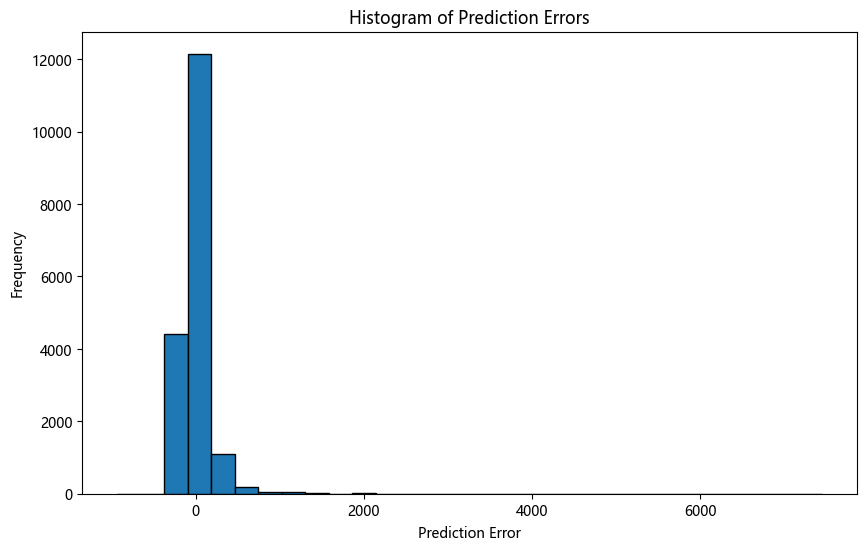

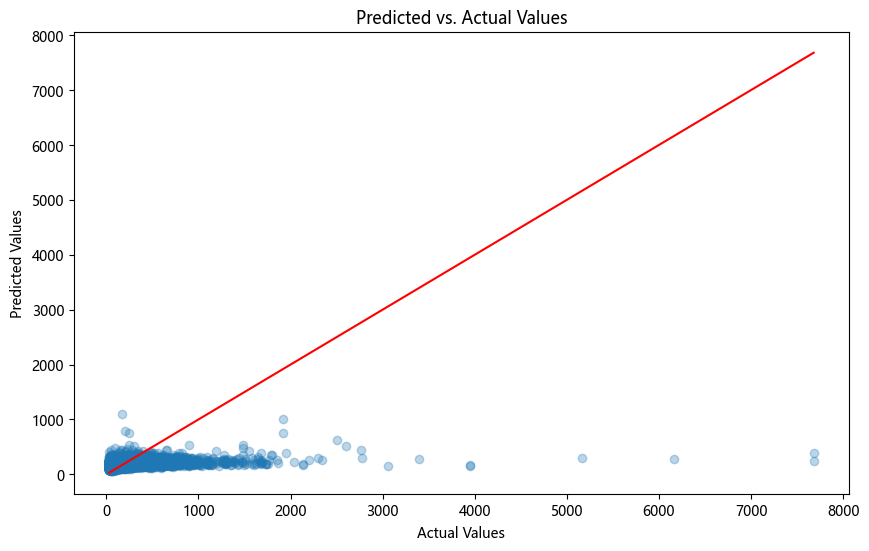

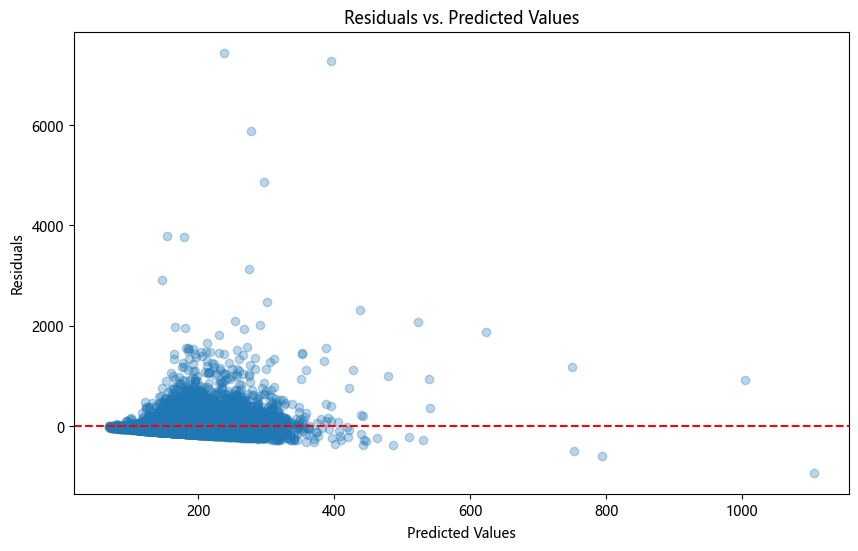

In [15]:
# 回歸評估
y_pred = grid_search.best_estimator_.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R^2 Score: {r2}')

residuals = y_test - y_pred

# 繪製誤差直方圖
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, edgecolor='black')
plt.title('Histogram of Prediction Errors')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.show()

# 繪製預測值與實際值的散點圖
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.title('Predicted vs. Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red')  # 對角線
plt.show()

# 繪製殘差圖
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.3)
plt.title('Residuals vs. Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='red', linestyle='--')
plt.show()

In [16]:
%%time
# 級距分類

from sklearn.model_selection import GridSearchCV

y = df['span']  

# 拆分數據集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=87)

# 超參數組合
param_grid = {
    'n_estimators': [200, 300],  # 樹的數量
    'max_features': ['sqrt', 'log2'],  # 劃分時考慮的最大特徵數
    'max_depth' : [6, 8, 10],  # 樹的最大深度
    'criterion' :['entropy']  # 劃分樹時的評估標準
}

# 創建隨機森林模型
rf_model = RandomForestClassifier(random_state=87)

# 使用 GridSearchCV 進行超參數搜尋
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# 適用於訓練集
grid_search.fit(X_train, y_train)

# 輸出最佳參數和評分
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 300}
Best Score: 0.33802777777777776
CPU times: total: 3min 27s
Wall time: 11min 53s


Accuracy: 0.3396666666666667
Precision: 0.3358372283352813
Recall: 0.3396666666666667
F1 Score: 0.33447724197701334


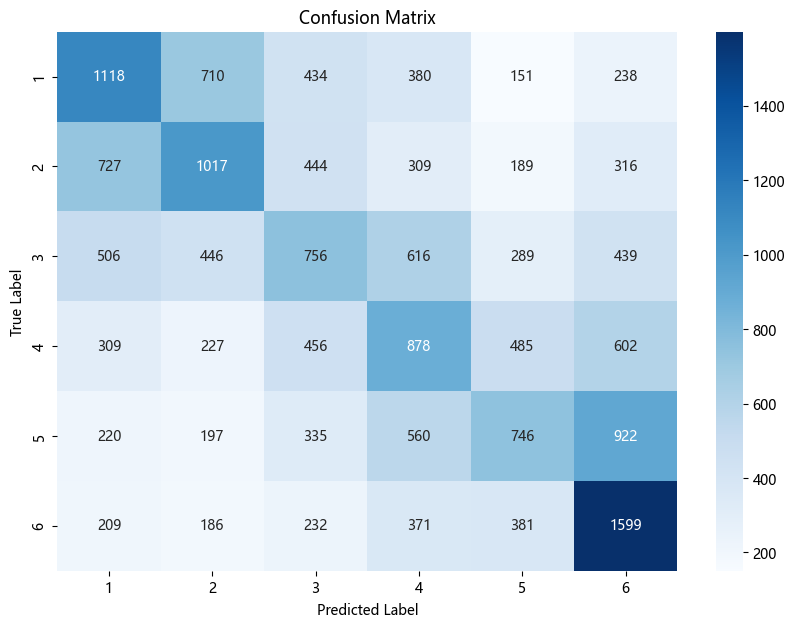

In [17]:
# 使用最佳模型預測
y_pred = grid_search.best_estimator_.predict(X_test)

# 計算評估指標
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# 混淆矩陣
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
class_names = [1, 2, 3, 4, 5, 6]  # 根据你的类别进行调整
plt.xticks(ticks=np.arange(len(class_names)) + 0.5, labels=class_names)
plt.yticks(ticks=np.arange(len(class_names)) + 0.5, labels=class_names)
plt.show()

# 特徵工程後

In [18]:
%%time
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from concurrent.futures import ThreadPoolExecutor
from sklearn.decomposition import PCA
from PIL import Image
import os
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

# 讀取 CSV 檔案
df = pd.read_csv('./final_raw.csv')

# 根據 'span' 欄位篩選數據
sampled_df_list = []
for category in df['span'].unique():
    category_df = df[df['span'] == category]
    sample_n = min(len(category_df), 15000)  # 每個類別取 15000 筆
    sampled_df_list.append(category_df.sample(n=sample_n, random_state=42))  # 隨機取樣

# 合併篩選後的數據
df = pd.concat(sampled_df_list)


# 圖片處理
def process_image(image_name, size=(64, 64)):
    image_path = os.path.join(images_folder, image_name)
    with Image.open(image_path) as img:
        img = img.convert('RGB').resize(size)
        img_array = np.array(img)

        # 應用CANNY邊緣檢測
        edges = cv2.Canny(img_array, 100, 200)

        # 計算色彩頻率，減少 bins 數量
        (hist, _) = np.histogram(img_array.ravel(), bins=128, range=(0, 256))
        hist = hist / hist.sum()

        # 結合特徵
        features = np.append(edges.flatten(), hist)

        return features

# 圖片目錄
images_folder = './flipped_img'  

# 處理所有圖片並將其作為特徵
with ThreadPoolExecutor(max_workers=12) as executor:
    df['image'] = list(executor.map(process_image, df['pic_id']))

# 將圖片數據展平並轉換為 NumPy 陣列
X_images = np.array(df['image'].tolist())


# 初始化 PCA，設定 n_components 為 16
incremental_pca = IncrementalPCA(n_components=16)

# IncrementalPCA 降维，可以分批次进行
for batch in np.array_split(X_images, 10): 
    incremental_pca.partial_fit(batch)

# 對圖片數據應用 PCA 降維
X_images_pca = incremental_pca.transform(X_images)

CPU times: total: 1h 14min 52s
Wall time: 30min 15s


In [21]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

#建立編碼物件
one_hot_encoder = OneHotEncoder(sparse=False)

#餐點類別與評論單熱編碼
sort_one_hot = one_hot_encoder.fit_transform(df[['sort']])
label_one_hot = one_hot_encoder.fit_transform(df[['label']])

#minmax物件
scaler = MinMaxScaler()

#經緯度minmax
latitude_scaled = scaler.fit_transform(df[['latitude']])
longitude_scaled = scaler.fit_transform(df[['longitude']])

#特徵
X = np.hstack((X_images_pca, sort_one_hot, label_one_hot, latitude_scaled, longitude_scaled))
#目標
y = df['price']



C:\Users\student\anaconda3\envs\da\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\student\anaconda3\envs\da\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [22]:
%%time
# 真實價格回歸
from sklearn.model_selection import GridSearchCV

# 拆分數據集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=87)

# 超參數組合
param_grid = {
    'n_estimators': [ 200, 300],  # 樹的數量
    'max_features': ['sqrt', 'log2'],  # 劃分時考慮的最大特徵數
    'max_depth' : [ 6, 8, 10],  # 樹的最大深度
    'criterion' :['squared_error']  # 劃分樹時的評估標準
}

# 創建隨機森林模型
rf_model = RandomForestRegressor(random_state=87)

# 使用 GridSearchCV 進行超參數搜尋
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# 適用於訓練集
grid_search.fit(X_train, y_train)

# 輸出最佳參數和評分
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Parameters: {'criterion': 'squared_error', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}
Best Score: 0.16647081022502352
CPU times: total: 1min 28s
Wall time: 5min 14s


Mean Squared Error: 38283.17765290718
Mean Absolute Error: 100.09618722325874
R^2 Score: 0.1267303856216786


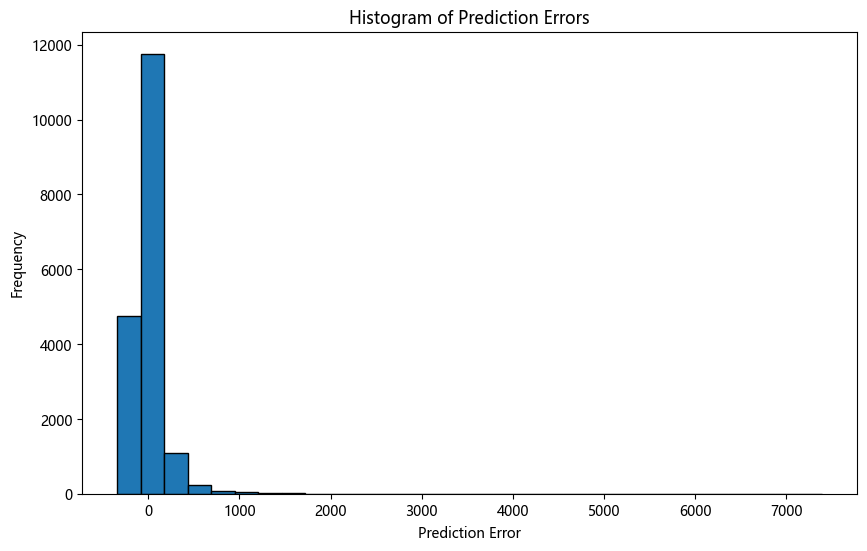

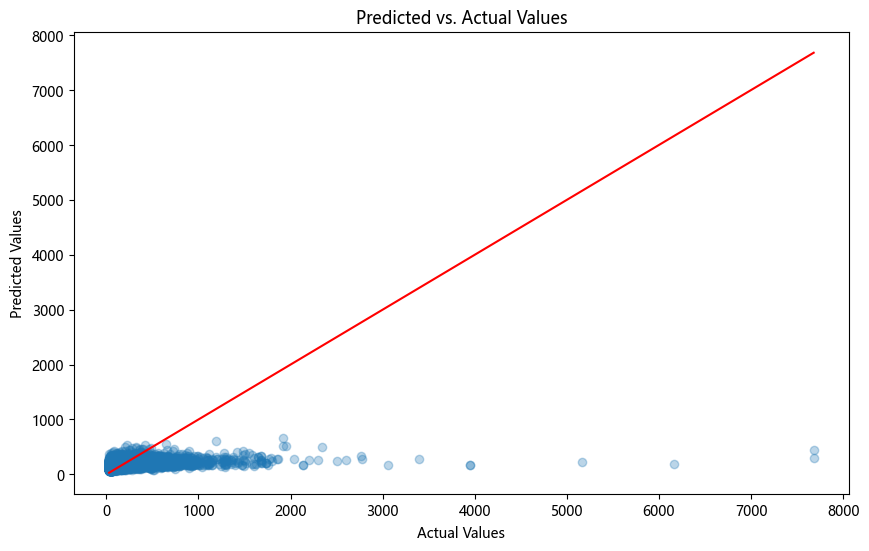

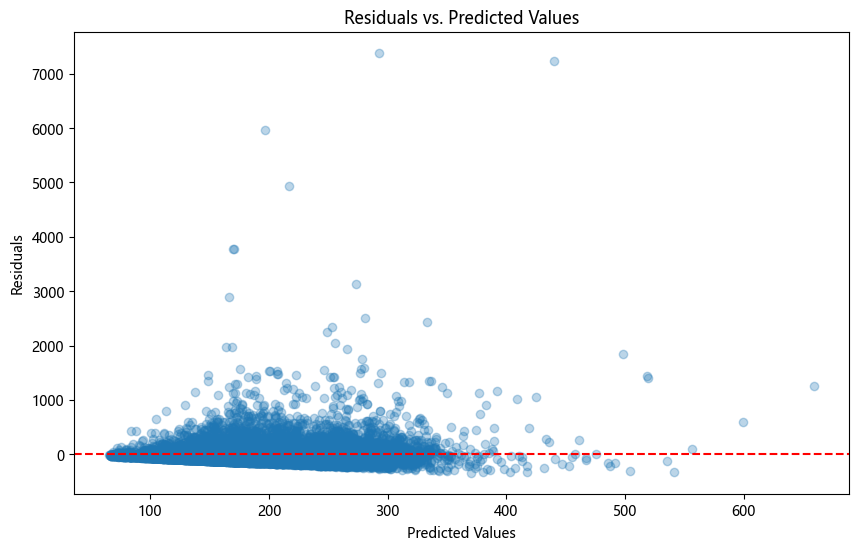

In [23]:
# 回歸評估
y_pred = grid_search.best_estimator_.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R^2 Score: {r2}')

residuals = y_test - y_pred

# 繪製誤差直方圖
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, edgecolor='black')
plt.title('Histogram of Prediction Errors')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.show()

# 繪製預測值與實際值的散點圖
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.title('Predicted vs. Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red')  # 對角線
plt.show()

# 繪製殘差圖
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.3)
plt.title('Residuals vs. Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='red', linestyle='--')
plt.show()

In [25]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

#建立編碼物件
one_hot_encoder = OneHotEncoder(sparse=False)

#餐點類別與評論單熱編碼
sort_one_hot = one_hot_encoder.fit_transform(df[['sort']])
label_one_hot = one_hot_encoder.fit_transform(df[['label']])

#minmax物件
scaler = MinMaxScaler()

#經緯度minmax
latitude_scaled = scaler.fit_transform(df[['latitude']])
longitude_scaled = scaler.fit_transform(df[['longitude']])

#特徵
X = np.hstack((X_images_pca, sort_one_hot, label_one_hot, latitude_scaled, longitude_scaled))
#目標
y = df['span']


C:\Users\student\anaconda3\envs\da\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\student\anaconda3\envs\da\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [26]:
%%time
# 級距分類

from sklearn.model_selection import GridSearchCV

# 拆分數據集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=87)

# 設定要嘗試的超參數範圍
param_grid = {
    'n_estimators': [ 200, 300],  # 樹的數量
    'max_features': ['sqrt', 'log2'],  # 劃分時考慮的最大特徵數
    'max_depth' : [ 6, 8, 10],  # 樹的最大深度
    'criterion' :['gini', 'entropy']  # 劃分樹時的評估標準
}

# 創建隨機森林模型
rf_model = RandomForestClassifier(random_state=87)

# 使用 GridSearchCV 進行超參數搜尋
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, n_jobs=5, verbose=2)

# 適用於訓練集
grid_search.fit(X_train, y_train)

# 輸出最佳參數和評分
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best Parameters: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 300}
Best Score: 0.338
CPU times: total: 2min 37s
Wall time: 19min 9s


Accuracy: 0.3376111111111111
Precision: 0.3373948215604958
Recall: 0.3376111111111111
F1 Score: 0.3331470582692236


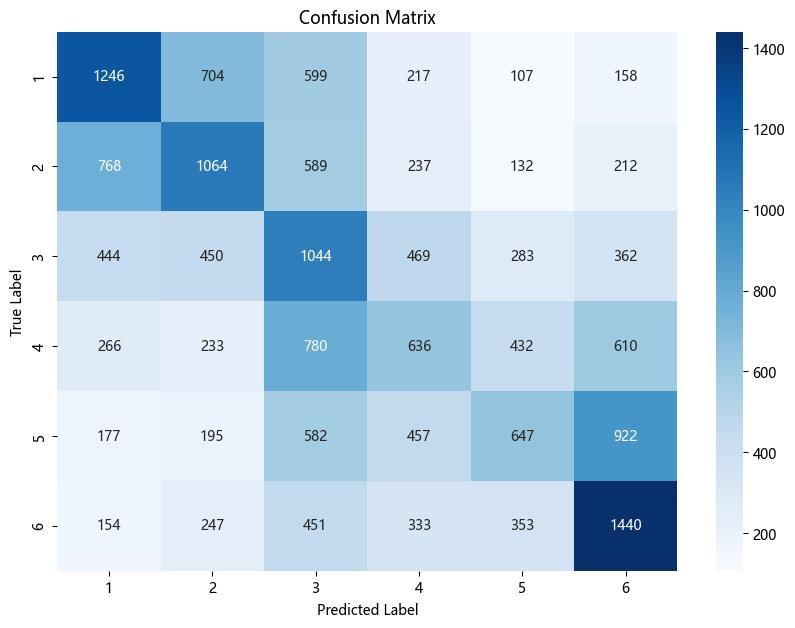

In [27]:
# 使用最佳模型進行預測
y_pred = grid_search.best_estimator_.predict(X_test)

# 計算各項評估指標
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# 混淆矩陣
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
class_names = [1, 2, 3, 4, 5, 6]  
plt.xticks(ticks=np.arange(len(class_names)) + 0.5, labels=class_names)
plt.yticks(ticks=np.arange(len(class_names)) + 0.5, labels=class_names)
plt.show()